In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '16_target_updated2'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/mnt/beegfs/home/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.isfile(merge_file):
    dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)

In [3]:
df.columns

Index(['replay_memory', 'run', 'target_update_freq', 'job_id', 'round_number',
       'sampling', 'update_step', 'metric', 'value'],
      dtype='object')

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id', 'run']

labels = [c for c in df.columns if c not in non_labels]


In [5]:
labels

['replay_memory', 'target_update_freq']

In [6]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '3.e-4',
    'memory_episodes': '100',
    'target_update_freq': '100',
    'hidden_size': '5',
    'features': 'contributions'
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'*'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,24.699838,0.041491,595.303651,0.000000e+00,24.618517,24.781159
replay_memory[T.100],-0.068462,0.058677,-1.166754,2.433098e-01,-0.183468,0.046543
replay_memory[T.1000],0.135775,0.058677,2.313922,2.067200e-02,0.020769,0.250780
"C(target_update_freq, Treatment(reference='100'))[T.10]",0.423181,0.058677,7.211998,5.513682e-13,0.308175,0.538186
"C(target_update_freq, Treatment(reference='100'))[T.1000]",0.102236,0.058677,1.742347,8.144781e-02,-0.012769,0.217242
"replay_memory[T.100]:C(target_update_freq, Treatment(reference='100'))[T.10]",0.040368,0.082982,0.486462,6.266395e-01,-0.122275,0.203010
"replay_memory[T.1000]:C(target_update_freq, Treatment(reference='100'))[T.10]",-0.424378,0.082982,-5.114072,3.152865e-07,-0.587020,-0.261735
"replay_memory[T.100]:C(target_update_freq, Treatment(reference='100'))[T.1000]",0.153303,0.082982,1.847420,6.468636e-02,-0.009339,0.315946
"replay_memory[T.1000]:C(target_update_freq, Treatment(reference='100'))[T.1000]",-0.161654,0.082982,-1.948048,5.140927e-02,-0.324296,0.000989


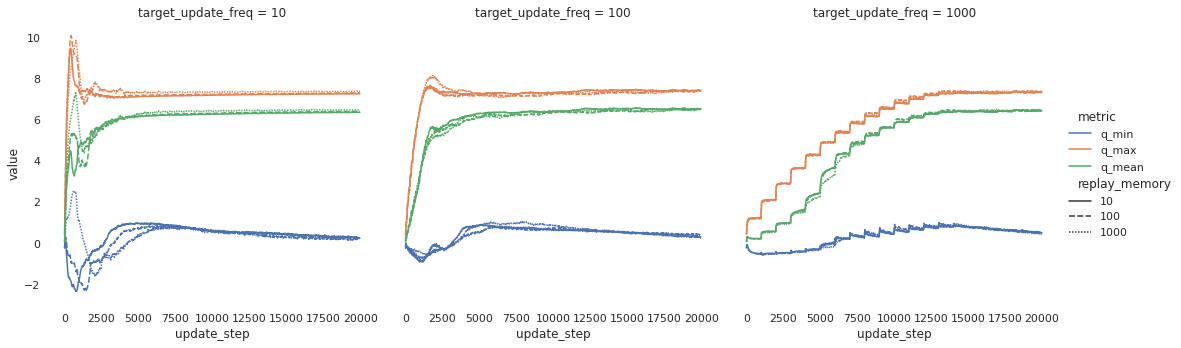

In [7]:
selection = {
    'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 
    'memory_episodes': 100, 'sampling': 'greedy', 
    'target_update_freq': 200, 'features': 'contributions',
    'artificial_humans': 'complex'}

focus = ['update_step', 'metric', 'replay_memory', 'target_update_freq']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

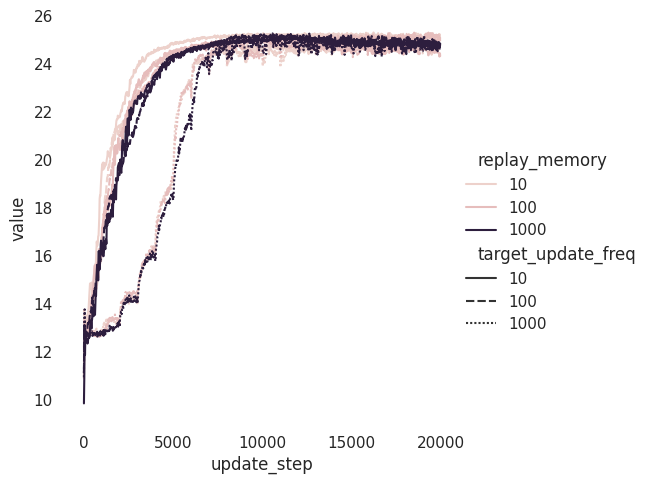

In [8]:
focus = ['update_step', 'replay_memory', 'target_update_freq']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

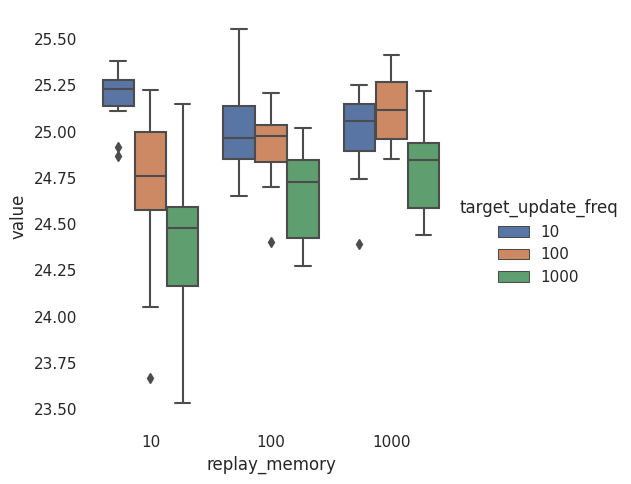

In [9]:
focus = ['replay_memory', 'target_update_freq']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['update_step'] > 8000) & (dfs['update_step'] < 12000)
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels + ['run'])['value'].mean().reset_index()

fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')